# LABORATORY SESSION - WEEK 12

## Understanding The Articles 

- What types of trolls are there in the database?
    - normal american citizens (comments on real time events)
    - local news outlets (violence)
    - local political party (republican)
- How to tell them apart?
    - community detection algorithm
- What do trolls do?
    - rigth wing (positive tweets)
    - left wing (negative tweets)
    - black lives matter community
- What hashtags they used?
    - reflect the community purpose

In [20]:
# import 
import networkx as nx 
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from datetime import datetime
import random
import matplotlib.patches as mpatches
import seaborn as sns 
from networkx.algorithms.community import girvan_newman
import ast  # To parse strings representing lists

### Problem 1 

Import tweeter data. Draw networks illustrating the relationships inside them. 

### Solution 

In [3]:
def load_dataset(file_path):
    """
    Load a dataset from a CSV file.
    
    Args:
        file_path (str): Path to the CSV file.
    
    Returns:
        pd.DataFrame: Loaded DataFrame.
    """
    return pd.read_csv(file_path)

def display_dataset_info(df, dataset_name):
    """
    Display basic information about a dataset.
    
    Args:
        df (pd.DataFrame): The DataFrame to analyze.
        dataset_name (str): Name of the dataset for display purposes.
    """
    print(f"\n{dataset_name} Dataset Dimensions:")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
    print(f"\n{dataset_name} Dataset Columns:")
    print(df.columns.tolist())

def display_example_row(df, dataset_name):
    """
    Display attribute-by-attribute details of an example row from a dataset.
    
    Args:
        df (pd.DataFrame): The DataFrame to analyze.
        dataset_name (str): Name of the dataset for display purposes.
    """
    print(f"\nExample Row from {dataset_name} Dataset (Attribute by Attribute):")
    example_row = df.iloc[0]
    for column, value in example_row.items():
        print(f"{column}: {value}")


# Data file paths
tweets_dir = "data/tweets.csv"
users_dir = "data/users.csv"
    
# Load datasets
tweets_df = load_dataset(tweets_dir)
users_df = load_dataset(users_dir)
    
# Display information about datasets
display_dataset_info(tweets_df, "Tweets")
display_dataset_info(users_df, "Users")
    
# Display example rows from each dataset
display_example_row(tweets_df, "Tweets")
display_example_row(users_df, "Users")


Tweets Dataset Dimensions:
Rows: 203451, Columns: 16

Tweets Dataset Columns:
['user_id', 'user_key', 'created_at', 'created_str', 'retweet_count', 'retweeted', 'favorite_count', 'text', 'tweet_id', 'source', 'hashtags', 'expanded_urls', 'posted', 'mentions', 'retweeted_status_id', 'in_reply_to_status_id']

Users Dataset Dimensions:
Rows: 453, Columns: 14

Users Dataset Columns:
['id', 'location', 'name', 'followers_count', 'statuses_count', 'time_zone', 'verified', 'lang', 'screen_name', 'description', 'created_at', 'favourites_count', 'friends_count', 'listed_count']

Example Row from Tweets Dataset (Attribute by Attribute):
user_id: 2532611755.0
user_key: kathiemrr
created_at: 1488207240000.0
created_str: 2017-02-27 14:54:00
retweet_count: nan
retweeted: nan
favorite_count: nan
text: #ThingsDoneByMistake kissing auntie in the lips
tweet_id: 8.362278918976512e+17
source: nan
hashtags: ["ThingsDoneByMistake"]
expanded_urls: []
posted: POSTED
mentions: []
retweeted_status_id: nan
in_r

In [15]:
def compute_user_activity(tweets_df):
    """
    Compute user activity metrics from the tweets dataset.

    Parameters:
    - tweets_df (DataFrame): The tweets dataset.

    Returns:
    - DataFrame: A DataFrame with user activity metrics.
    """
    user_activity = tweets_df.groupby(['user_id', 'user_key']).agg(
        tweets=('user_id', 'size'),
        retweets=('retweet_count', 'sum'),
        likes=('favorite_count', 'sum'),
        replies=('in_reply_to_status_id', lambda x: x.notna().sum()), 
        mentions=('mentions', lambda x: x.explode().value_counts().to_dict()),
    ).reset_index()

    return user_activity

# Add activity data from users dataset (e.g., statuses_count)
user_activity = compute_user_activity(tweets_df)

# Display the result
print(user_activity.head())

       user_id       user_key  tweets  retweets  likes  replies  \
0   38875764.0        leecory       1       0.0    0.0        0   
1   87588938.0         anzgri       3       0.0    0.0        0   
2  100345056.0    scottgohard      68      17.0   35.0        8   
3  247165706.0    beckster319      56       1.0    1.0        2   
4  249538861.0  skatewake1994      23       1.0    0.0        0   

                                            mentions  
0                           {'["thebaxterbean"]': 1}  
1                                          {'[]': 3}  
2  {'["realdonaldtrump"]': 34, '[]': 9, '["realdo...  
3  {'[]': 24, '["hillaryclinton"]': 3, '["goldeng...  
4  {'[]': 7, '["benshapiro"]': 2, '["marycmccorma...  


In [16]:
# Function to display a few example rows feature-by-feature
def display_example_rows(df, num_rows=3):
    print(f"Displaying {num_rows} example rows from the DataFrame:\n")
    for idx in df.head(num_rows).index:
        print(f"\nExample Row (Index: {idx}):")
        row = df.loc[idx]
        for column, value in row.items():
            print(f"{column}: {value}")

# Show 5 example rows from the user_activity DataFrame
display_example_rows(user_activity, num_rows=5)

Displaying 5 example rows from the DataFrame:


Example Row (Index: 0):
user_id: 38875764.0
user_key: leecory
tweets: 1
retweets: 0.0
likes: 0.0
replies: 0
mentions: {'["thebaxterbean"]': 1}

Example Row (Index: 1):
user_id: 87588938.0
user_key: anzgri
tweets: 3
retweets: 0.0
likes: 0.0
replies: 0
mentions: {'[]': 3}

Example Row (Index: 2):
user_id: 100345056.0
user_key: scottgohard
tweets: 68
retweets: 17.0
likes: 35.0
replies: 8
mentions: {'["realdonaldtrump"]': 34, '[]': 9, '["realdonaldtrump","gop"]': 2, '["uniqueloves","kokopellient","realdlhughley","realdonaldtrump","zakeyamasada","lipps_ms"]': 1, '["brandonvdixon"]': 1, '["yusefsalaam","santanaraymond"]': 1, '["santanaraymond","yusefsalaam","realdonaldtrump"]': 1, '["santanaraymond","hillaryclinton","yusefsalaam"]': 1, '["realdlhughley","dlhughleyradio"]': 1, '["vp","potus"]': 1, '["oreillyfactor","realdonaldtrump"]': 1, '["barackobama","realdonaldtrump"]': 1, '["realdonaldtrump","creflo_dollar"]': 1, '["yusefsalaam","realdonal

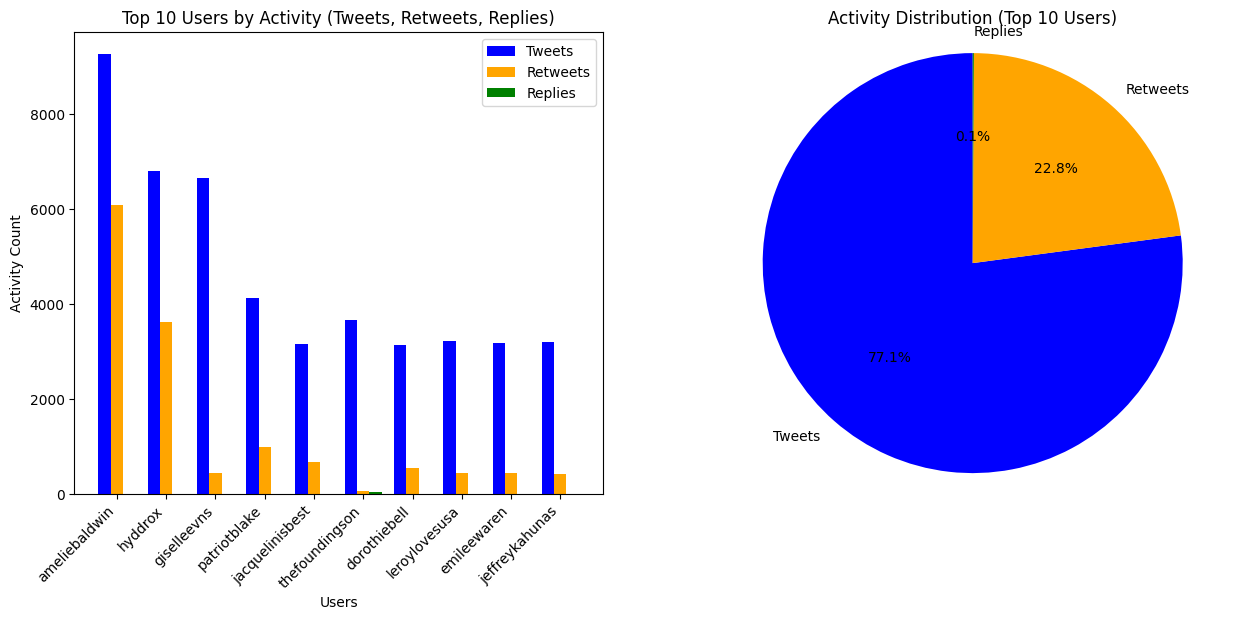

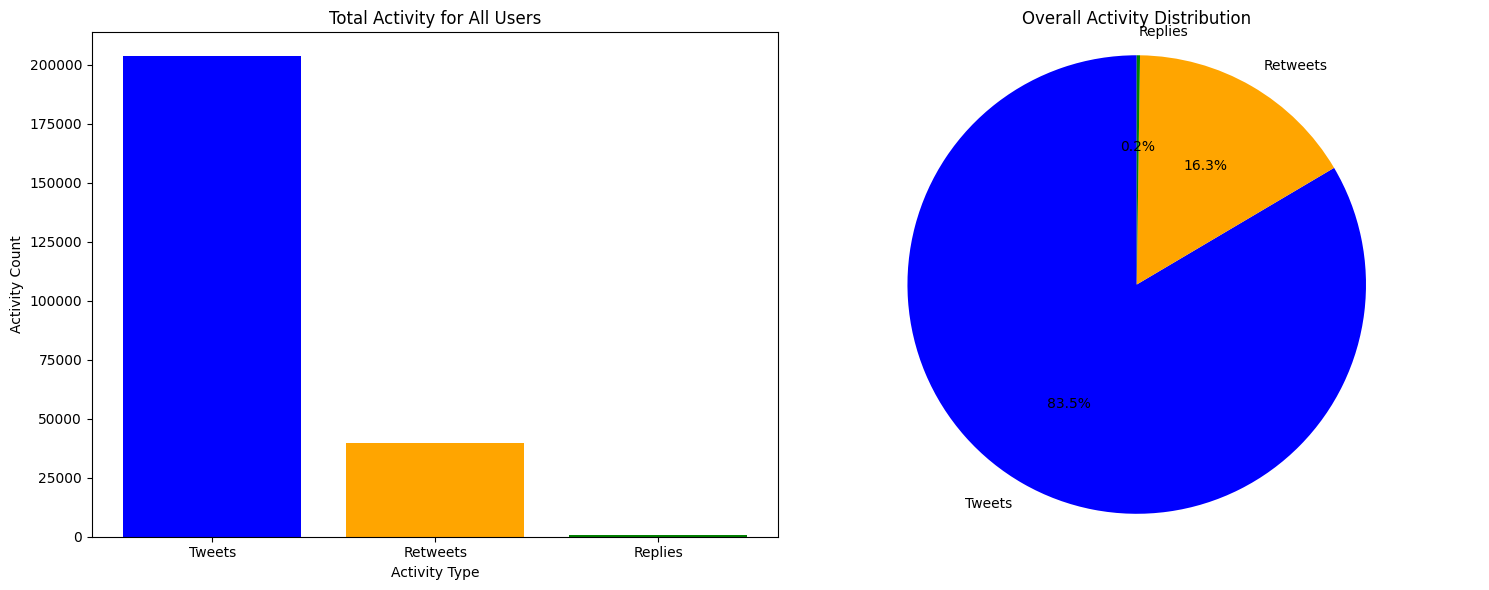

In [17]:
def analyze_and_plot_user_activity(user_activity):
    """
    Analyze and plot user activity metrics.

    Parameters:
    - user_activity (DataFrame): A DataFrame with user activity metrics including 'tweets', 'retweets', and 'replies'.

    Returns:
    - None: Displays plots for top users and overall activity distribution.
    """
    # Calculate total activity and sort for top users
    user_activity['total_activity'] = user_activity['tweets'] + user_activity['retweets'] + user_activity['replies']
    top_users = user_activity.sort_values(by='total_activity', ascending=False).head(10)

    # Calculate overall activity metrics
    total_tweets = user_activity['tweets'].sum()
    total_retweets = user_activity['retweets'].sum()
    total_replies = user_activity['replies'].sum()

    # Prepare for plotting
    x = np.arange(len(top_users))
    width = 0.25  # Bar width

    # Create subplots for visualizations
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # Bar chart for top users' tweets, retweets, and replies
    ax[0].bar(x - width, top_users['tweets'], width, label='Tweets', color='blue')
    ax[0].bar(x, top_users['retweets'], width, label='Retweets', color='orange')
    ax[0].bar(x + width, top_users['replies'], width, label='Replies', color='green')

    ax[0].set_xticks(x)
    ax[0].set_xticklabels(top_users['user_key'], rotation=45, ha='right')
    ax[0].set_xlabel('Users')
    ax[0].set_ylabel('Activity Count')
    ax[0].set_title('Top 10 Users by Activity (Tweets, Retweets, Replies)')
    ax[0].legend()

    # Pie chart for activity distribution among top users
    activities = [top_users['tweets'].sum(), top_users['retweets'].sum(), top_users['replies'].sum()]
    labels = ['Tweets', 'Retweets', 'Replies']
    colors = ['blue', 'orange', 'green']

    ax[1].pie(activities, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax[1].axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.
    ax[1].set_title('Activity Distribution (Top 10 Users)')

    # Plotting total activity for all users
    fig2, ax2 = plt.subplots(1, 2, figsize=(15, 6))

    # Bar chart for total tweets, retweets, and replies
    ax2[0].bar(['Tweets', 'Retweets', 'Replies'], [total_tweets, total_retweets, total_replies], color=['blue', 'orange', 'green'])
    ax2[0].set_xlabel('Activity Type')
    ax2[0].set_ylabel('Activity Count')
    ax2[0].set_title('Total Activity for All Users')

    # Pie chart for overall activity distribution
    total_activities = [total_tweets, total_retweets, total_replies]
    ax2[1].pie(total_activities, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax2[1].axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.
    ax2[1].set_title('Overall Activity Distribution')

    # Adjust layout and show plots
    plt.tight_layout()
    plt.show()


# Plot the activity for the top users and the entire user base
plot_user_activity(top_users, user_activity)


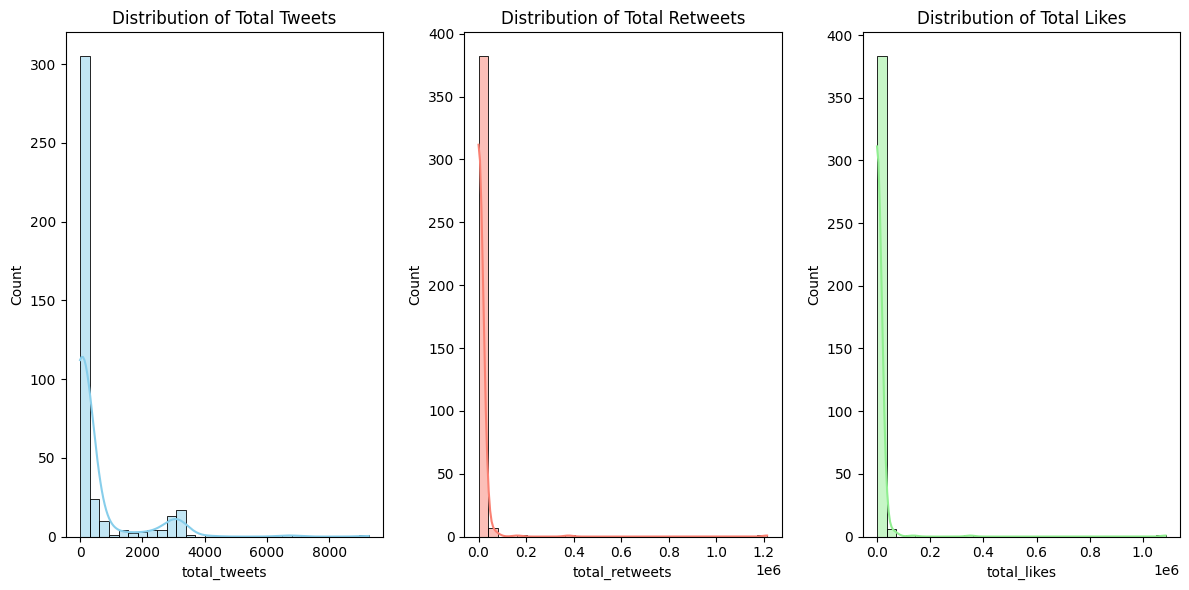

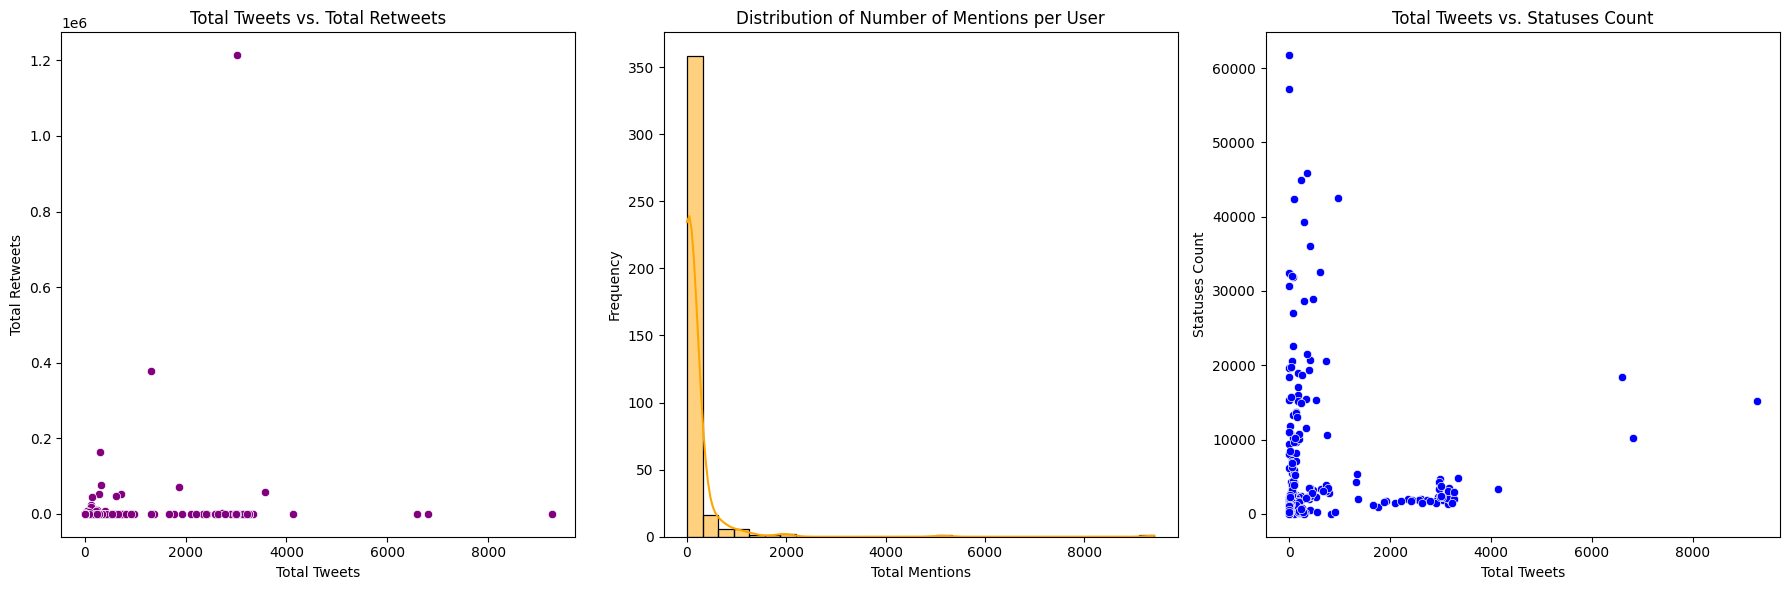

In [18]:
# Merging the datasets to connect tweets with user information
user_tweet_stats = pd.merge(
    tweets_df.groupby('user_id').agg(
        total_tweets=('tweet_id', 'count'),
        total_retweets=('retweet_count', 'sum'),
        total_likes=('favorite_count', 'sum'),
        total_mentions=('mentions', lambda x: sum([len(eval(m)) for m in x if m != '[]']))  # Count mentions
    ).reset_index(),
    users_df[['id', 'statuses_count', 'screen_name']],
    left_on='user_id', right_on='id', how='left'
)

# 1. Distribution of total tweets, retweets, and likes for users
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.histplot(user_tweet_stats['total_tweets'], kde=True, color='skyblue', bins=30)
plt.title('Distribution of Total Tweets')

plt.subplot(1, 3, 2)
sns.histplot(user_tweet_stats['total_retweets'], kde=True, color='salmon', bins=30)
plt.title('Distribution of Total Retweets')

plt.subplot(1, 3, 3)
sns.histplot(user_tweet_stats['total_likes'], kde=True, color='lightgreen', bins=30)
plt.title('Distribution of Total Likes')

plt.tight_layout()
plt.show()

# Create subplots to display all three plots in one row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 2. Total Tweets vs. Total Retweets
sns.scatterplot(x='total_tweets', y='total_retweets', data=user_tweet_stats, color='purple', ax=axes[0])
axes[0].set_title('Total Tweets vs. Total Retweets')
axes[0].set_xlabel('Total Tweets')
axes[0].set_ylabel('Total Retweets')

# 3. Number of Mentions per User
sns.histplot(user_tweet_stats['total_mentions'], kde=True, color='orange', bins=30, ax=axes[1])
axes[1].set_title('Distribution of Number of Mentions per User')
axes[1].set_xlabel('Total Mentions')
axes[1].set_ylabel('Frequency')

# 4. Comparison of Activity (Total Tweets vs Status Count)
sns.scatterplot(x='total_tweets', y='statuses_count', data=user_tweet_stats, color='blue', ax=axes[2])
axes[2].set_title('Total Tweets vs. Statuses Count')
axes[2].set_xlabel('Total Tweets')
axes[2].set_ylabel('Statuses Count')

# Adjust layout for better spacing between plots
plt.tight_layout()

# Show the plots
plt.show()


In [24]:
def extract_retweets(tweets_df):
    """Extract retweet interactions."""
    retweets = tweets_df[~tweets_df['retweeted_status_id'].isna()][['user_id', 'retweeted_status_id', 'created_at']]
    retweets = retweets.rename(columns={'user_id': 'source_user_id', 'retweeted_status_id': 'target_user_id'})
    retweets['interaction_type'] = 'retweet'
    return retweets

def extract_replies(tweets_df):
    """Extract reply interactions."""
    replies = tweets_df[~tweets_df['in_reply_to_status_id'].isna()][['user_id', 'in_reply_to_status_id', 'created_at']]
    replies = replies.rename(columns={'user_id': 'source_user_id', 'in_reply_to_status_id': 'target_user_id'})
    replies['interaction_type'] = 'reply'
    return replies

def extract_mentions(tweets_df):
    """Extract mention interactions."""
    def parse_mentions(row):
        try:
            mentions = ast.literal_eval(row['mentions'])
            return [(row['user_id'], mention) for mention in mentions]
        except (ValueError, SyntaxError):
            return []

    mention_interactions = tweets_df.apply(parse_mentions, axis=1).explode().dropna()
    mentions = pd.DataFrame(mention_interactions.tolist(), columns=['source_user_id', 'target_user_id'])
    mentions['interaction_type'] = 'mention'
    mentions['created_at'] = tweets_df.loc[mention_interactions.index, 'created_at'].values
    return mentions

def merge_with_user_details(interactions_df, users_df):
    """Merge interactions with user details."""
    # Ensure consistent data types for merging columns
    interactions_df['source_user_id'] = interactions_df['source_user_id'].astype(str)
    interactions_df['target_user_id'] = interactions_df['target_user_id'].astype(str)
    users_df['id'] = users_df['id'].astype(str)

    # Merge with source user details
    interactions_df = interactions_df.merge(
        users_df[['id', 'screen_name']],
        left_on='source_user_id',
        right_on='id',
        how='left'
    ).rename(columns={'screen_name': 'source_screen_name'})

    # Merge with target user details
    interactions_df = interactions_df.merge(
        users_df[['id', 'screen_name']],
        left_on='target_user_id',
        right_on='id',
        how='left'
    ).rename(columns={'screen_name': 'target_screen_name'})

    # Select relevant columns
    interactions_df = interactions_df[
        ['source_user_id', 'source_screen_name', 'target_user_id', 'target_screen_name', 'interaction_type', 'created_at']
    ]
    return interactions_df

def create_user_interaction_dataframe(tweets_df, users_df):
    """Create a DataFrame with all user interactions."""
    retweets = extract_retweets(tweets_df)
    replies = extract_replies(tweets_df)
    mentions = extract_mentions(tweets_df)

    # Combine all interactions
    interactions_df = pd.concat([retweets, replies, mentions], ignore_index=True)
    
    # Merge with user details
    interactions_df = merge_with_user_details(interactions_df, users_df)
    
    return interactions_df

# Create user interaction DataFrame
interactions_df = create_user_interaction_dataframe(tweets_df, users_df)
    
# Display the final DataFrame
print(interactions_df.head())

# Show 5 example rows from the interactions_df DataFrame
display_example_rows(interactions_df, num_rows=5)

  source_user_id source_screen_name         target_user_id target_screen_name  \
0   1694026190.0    JacquelinIsBest  7.775914782060298e+17                NaN   
1   1647045721.0    CarrieThornthon  7.853264195094118e+17                NaN   
2   2589353987.0       CassieWeltch  7.954637826717983e+17                NaN   
3   1649967228.0         _NickLuna_  7.778545242454467e+17                NaN   
4   1660771422.0    GarrettSimpson_  7.890041907565281e+17                NaN   

  interaction_type    created_at  
0          retweet  1.474228e+12  
1          retweet  1.476133e+12  
2          retweet  1.478535e+12  
3          retweet  1.474291e+12  
4          retweet  1.476949e+12  
Displaying 5 example rows from the DataFrame:


Example Row (Index: 0):
source_user_id: 1694026190.0
source_screen_name: JacquelinIsBest
target_user_id: 7.775914782060298e+17
target_screen_name: nan
interaction_type: retweet
created_at: 1474227985000.0

Example Row (Index: 1):
source_user_id: 164704572

Unique Source Users: 335
Unique Target Users: 46691
Total Interactions: 99439


C:\Users\39392\AppData\Local\Temp\ipykernel_2940\453474639.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=interaction_counts.index, y=interaction_counts.values, palette="viridis")


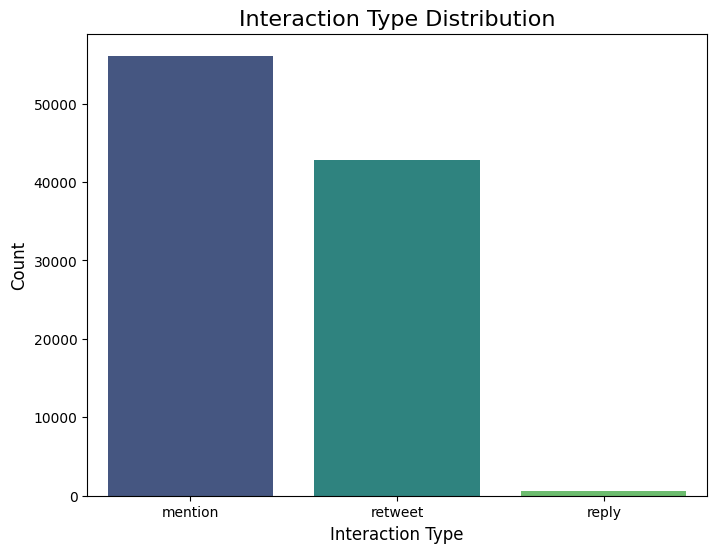

C:\Users\39392\AppData\Local\Temp\ipykernel_2940\453474639.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_source_users.values, y=top_source_users.index, palette="coolwarm")


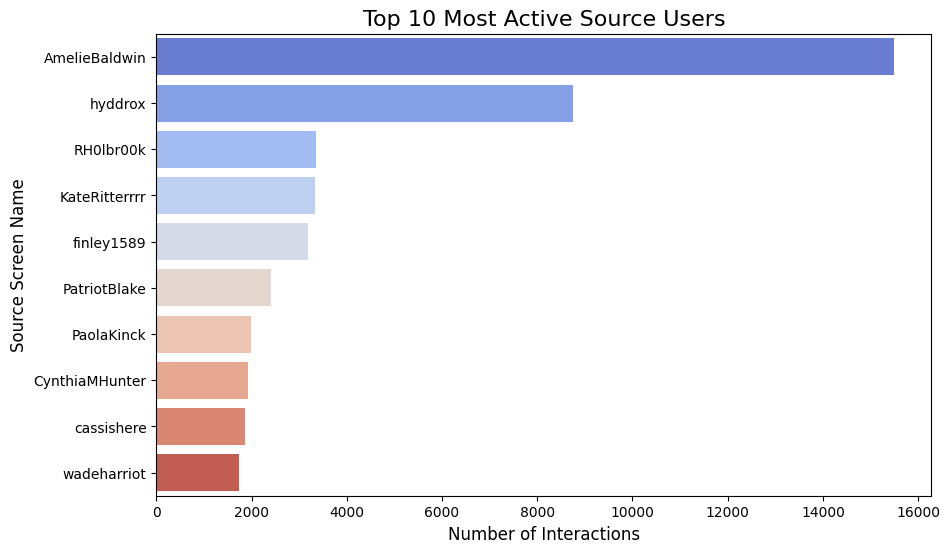

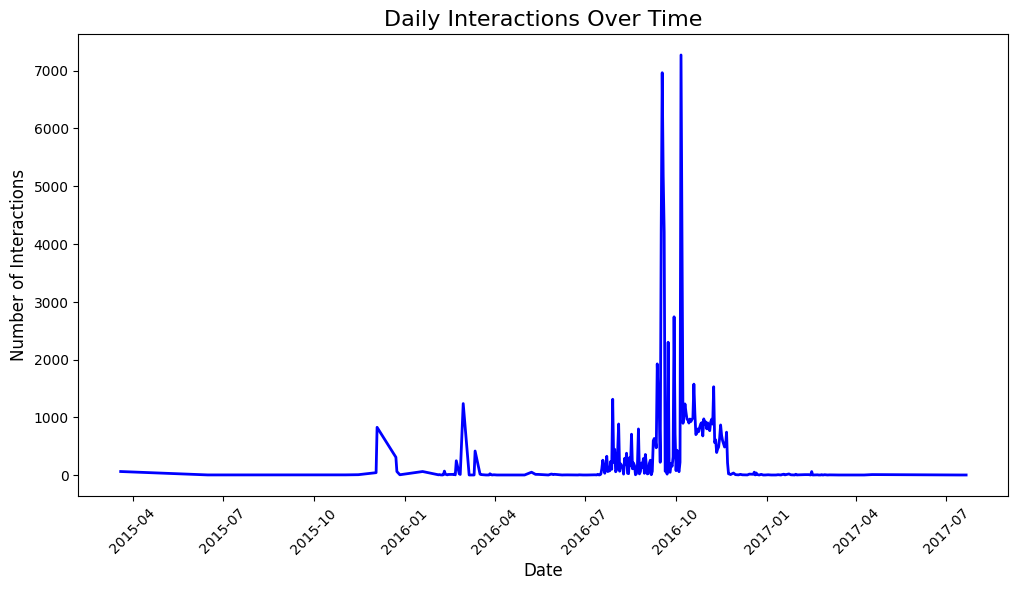

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def plot_user_interaction_insights(df):
    """
    Analyze and plot insights related to user interactions in the given DataFrame.

    Parameters:
    - df (pd.DataFrame): DataFrame with columns 'source_user_id', 'source_screen_name', 
      'target_user_id', 'target_screen_name', 'interaction_type', and 'created_at'.

    Returns:
    - None: Displays various plots and insights.
    """
    # Ensure required columns exist
    required_columns = {'source_user_id', 'source_screen_name', 'target_user_id', 'interaction_type', 'created_at'}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"The DataFrame must contain the following columns: {', '.join(required_columns)}")

    # Parse timestamps
    df['created_at'] = pd.to_datetime(df['created_at'], unit='ms')

    # General stats
    unique_source_users = df['source_user_id'].nunique()
    unique_target_users = df['target_user_id'].nunique()
    total_interactions = len(df)

    print(f"Unique Source Users: {unique_source_users}")
    print(f"Unique Target Users: {unique_target_users}")
    print(f"Total Interactions: {total_interactions}")

    # Interaction type counts
    interaction_counts = df['interaction_type'].value_counts()

    # Plot interaction type distribution
    plt.figure(figsize=(8, 6))
    sns.barplot(x=interaction_counts.index, y=interaction_counts.values, palette="viridis")
    plt.title("Interaction Type Distribution", fontsize=16)
    plt.xlabel("Interaction Type", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.show()

    # Most active source users (top 10)
    top_source_users = df['source_screen_name'].value_counts().head(10)
    
    # Plot top source users
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_source_users.values, y=top_source_users.index, palette="coolwarm")
    plt.title("Top 10 Most Active Source Users", fontsize=16)
    plt.xlabel("Number of Interactions", fontsize=12)
    plt.ylabel("Source Screen Name", fontsize=12)
    plt.show()

    # Activity over time
    df['date'] = df['created_at'].dt.date
    daily_interactions = df.groupby('date').size()

    # Plot activity over time
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=daily_interactions.index, y=daily_interactions.values, color='blue', linewidth=2)
    plt.title("Daily Interactions Over Time", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Number of Interactions", fontsize=12)
    plt.xticks(rotation=45)
    plt.show()

plot_user_interaction_insights(interactions_df)

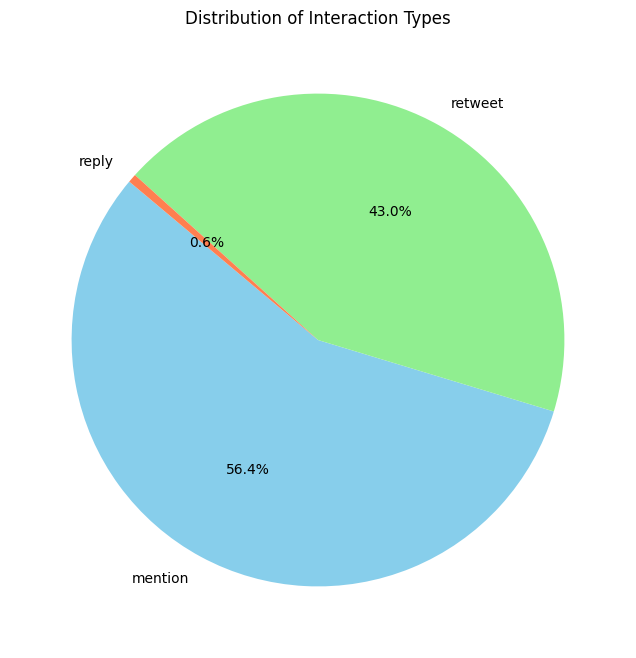

Unique Source Users: 335
Unique Target Users: 46691
Total Unique Users: 47026


In [29]:
# Pie chart for interaction types
def plot_interaction_distribution(interactions_df):
    """Plot a pie chart of interaction types."""
    interaction_counts = interactions_df['interaction_type'].value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(
        interaction_counts,
        labels=interaction_counts.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=['skyblue', 'lightgreen', 'coral']
    )
    plt.title("Distribution of Interaction Types")
    plt.show()

# Count unique users
def count_unique_users(interactions_df):
    """Count unique users in the interactions dataframe."""
    unique_sources = interactions_df['source_user_id'].nunique()
    unique_targets = interactions_df['target_user_id'].nunique()
    total_unique_users = pd.concat([
        interactions_df['source_user_id'],
        interactions_df['target_user_id']
    ]).nunique()
    print(f"Unique Source Users: {unique_sources}")
    print(f"Unique Target Users: {unique_targets}")
    print(f"Total Unique Users: {total_unique_users}")


# Plot the pie chart
plot_interaction_distribution(interactions_df)
    
# Count unique users
count_unique_users(interactions_df)

In [35]:
def create_twitter_network(users_df: pd.DataFrame, tweets_df: pd.DataFrame) -> nx.Graph:
    """
    Creates an undirected graph representing a Twitter network based on user interactions.
    
    Parameters:
        users_df (pd.DataFrame): DataFrame with user data containing ['id', 'name', 'location']
        tweets_df (pd.DataFrame): DataFrame with tweet data containing 
                                  ['user_id', 'mentions', 'retweeted_status_id', 'tweet_id', 'text']
    
    Returns:
        nx.Graph: Undirected graph where nodes are users and edges represent interactions.
    """
    # Initialize graph
    G = nx.Graph()

    def add_users_from_dataframe():
        """Add users from users_df as nodes with attributes."""
        for _, user in users_df.iterrows():
            user_id = user['id']
            if pd.notnull(user_id):
                G.add_node(
                    user_id,
                    name=str(user.get('name', '')),
                    location=str(user.get('location', '')),
                    type='user'
                )

    def add_users_from_tweets():
        """Add users found in tweets but not in users_df."""
        tweet_users = pd.unique(tweets_df['user_id'].dropna())
        for user_id in tweet_users:
            if pd.notnull(user_id) and not G.has_node(user_id):
                G.add_node(
                    user_id,
                    name=f"User_{user_id}",
                    location="Unknown",
                    type='user'
                )

    def add_interaction_edges():
        """Add edges based on mentions, retweets, and replies."""
        for _, tweet in tweets_df.iterrows():
            source_id = tweet['user_id']
            if pd.isnull(source_id):
                continue
            
            # Handle mentions
            mentions = tweet.get('mentions', [])
            if isinstance(mentions, list):
                for target_id in mentions:
                    if pd.notnull(target_id) and source_id != target_id:
                        # Add or update edge for mention
                        weight = 1  # Default weight for mention
                        if G.has_edge(source_id, target_id):
                            G[source_id][target_id]['weight'] += weight
                            G[source_id][target_id]['mentions'].append(tweet['tweet_id'])
                        else:
                            G.add_edge(
                                source_id,
                                target_id,
                                weight=weight,
                                type='mention',
                                mentions=[tweet['tweet_id']]
                            )

            # Handle retweets
            retweeted_status_id = tweet.get('retweeted_status_id')
            if pd.notnull(retweeted_status_id):
                # Find the user who posted the original tweet
                original_tweet = tweets_df[tweets_df['tweet_id'] == retweeted_status_id]
                if not original_tweet.empty:
                    target_id = original_tweet.iloc[0]['user_id']
                    if pd.notnull(target_id) and source_id != target_id:
                        # Add or update edge for retweet
                        weight = 1  # Default weight for retweet
                        if G.has_edge(source_id, target_id):
                            G[source_id][target_id]['weight'] += weight
                            G[source_id][target_id]['retweets'].append(tweet['tweet_id'])
                        else:
                            G.add_edge(
                                source_id,
                                target_id,
                                weight=weight,
                                type='retweet',
                                retweets=[tweet['tweet_id']]
                            )

            # Handle replies (if applicable)
            # Assuming replies are identified by the presence of a 'reply_to_tweet_id' field
            reply_to_tweet_id = tweet.get('reply_to_tweet_id')
            if pd.notnull(reply_to_tweet_id):
                # Find the user who posted the original tweet being replied to
                original_reply_tweet = tweets_df[tweets_df['tweet_id'] == reply_to_tweet_id]
                if not original_reply_tweet.empty:
                    target_id = original_reply_tweet.iloc[0]['user_id']
                    if pd.notnull(target_id) and source_id != target_id:
                        # Add or update edge for reply
                        weight = 1  # Default weight for reply
                        if G.has_edge(source_id, target_id):
                            G[source_id][target_id]['weight'] += weight
                            G[source_id][target_id]['replies'].append(tweet['tweet_id'])
                        else:
                            G.add_edge(
                                source_id,
                                target_id,
                                weight=weight,
                                type='reply',
                                replies=[tweet['tweet_id']]
                            )

    # Build network
    add_users_from_dataframe()
    add_users_from_tweets()
    add_interaction_edges()

    # Remove isolated nodes (users with no interactions)
    G.remove_nodes_from(list(nx.isolates(G)))

    return G

def get_network_stats(G: nx.Graph) -> dict:
    """
    Calculate basic network statistics.
    
    Parameters:
        G (nx.Graph): NetworkX graph object
    
    Returns:
        dict: Dictionary containing network statistics
    """
    return {
        'num_nodes': G.number_of_nodes(),
        'num_edges': G.number_of_edges(),
        'density': nx.density(G),
        'avg_degree': sum(dict(G.degree()).values()) / G.number_of_nodes(),
        'num_components': nx.number_connected_components(G),
        'largest_component_size': len(max(nx.connected_components(G), key=len)),
        'avg_clustering': nx.average_clustering(G),
        'mention_edges': sum(1 for _, _, d in G.edges(data=True) if d.get('type') == 'mention'),
        'retweet_edges': sum(1 for _, _, d in G.edges(data=True) if d.get('type') == 'retweet'),
        'reply_edges': sum(1 for _, _, d in G.edges(data=True) if d.get('type') == 'reply')
    }

# Example usage
tweets_dir = "data/tweets.csv"
users_dir = "data/users.csv"
tweets_df = pd.read_csv(tweets_dir)
users_df = pd.read_csv(users_dir)

# Create network
G = create_twitter_network(users_df, tweets_df)

# Get network statistics
stats = get_network_stats(G)
print("\nNetwork Statistics:")
for key, value in stats.items():
    print(f"{key}: {value:.2f}" if isinstance(value, float) else f"{key}: {value}")


Network Statistics:
num_nodes: 136
num_edges: 540
density: 0.06
avg_degree: 7.94
num_components: 4
largest_component_size: 129
avg_clustering: 0.36
mention_edges: 0
retweet_edges: 540
reply_edges: 0


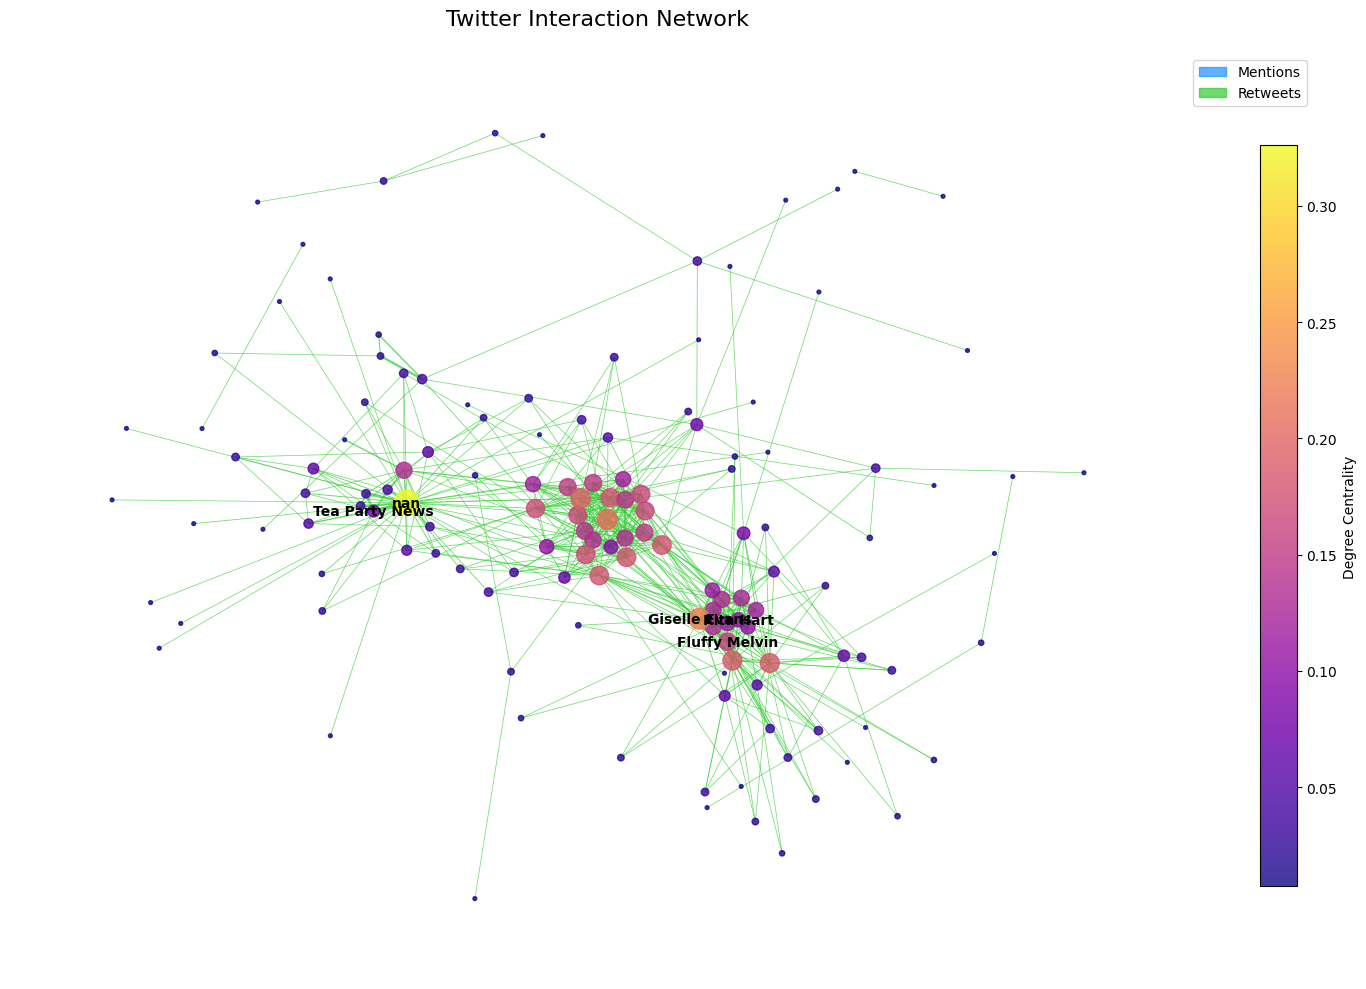

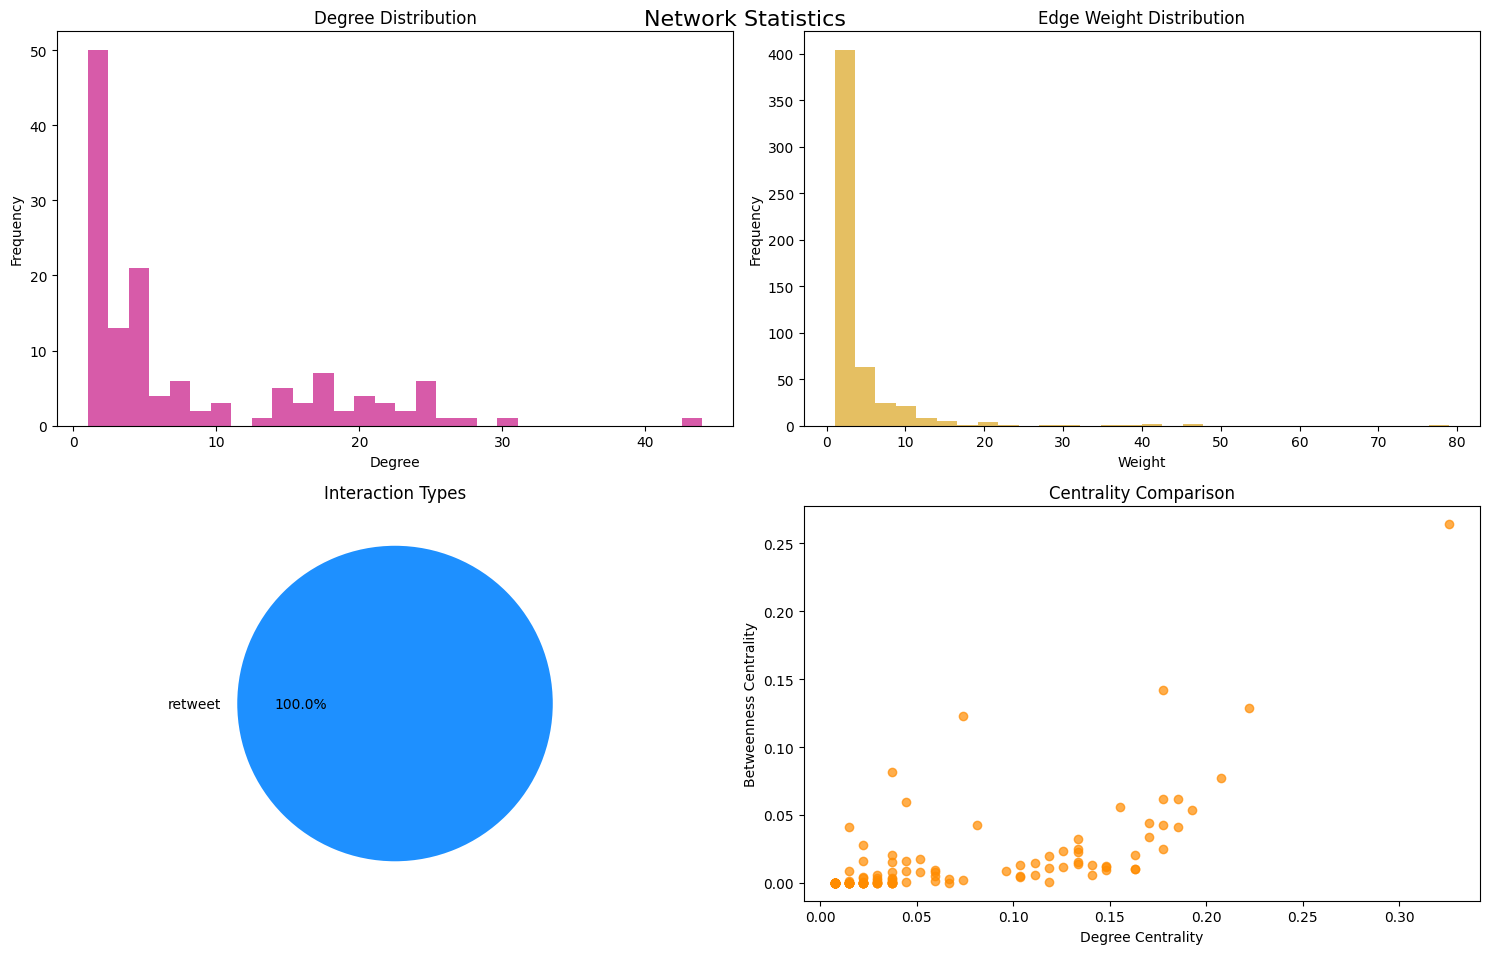

In [36]:
def visualize_network(G, title="Twitter Interaction Network", figsize=(15, 10)):
    """
    Creates an enhanced visualization of the Twitter interaction network.
    
    Parameters:
        G (nx.Graph): NetworkX graph of Twitter interactions
        title (str): Title for the visualization
        figsize (tuple): Figure size in inches
    """
    # Create figure
    plt.figure(figsize=figsize)
    plt.axis('off')
    
    # Calculate node sizes based on degree centrality
    degree_cent = nx.degree_centrality(G)
    node_sizes = [1000 * degree_cent[node] for node in G.nodes()]
    
    # Calculate edge weights for thickness
    edge_weights = [G[u][v].get('weight', 1) for u, v in G.edges()]
    max_weight = max(edge_weights)
    normalized_weights = [0.5 + 2.0 * (w / max_weight) for w in edge_weights]
    
    # Set up layout
    pos = nx.spring_layout(G, k=0.4, seed=42)
    
    # Separate edges by type
    mention_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'mention']
    retweet_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'retweet']
    
    # Draw edges
    nx.draw_networkx_edges(G, pos,
                          edgelist=mention_edges,
                          edge_color='dodgerblue',  # changed for clarity
                          alpha=0.7,
                          width=[normalized_weights[i] for i, (u, v) in enumerate(G.edges()) 
                                if (u, v) in mention_edges or (v, u) in mention_edges])
    
    nx.draw_networkx_edges(G, pos,
                          edgelist=retweet_edges,
                          edge_color='limegreen',  # changed for clarity
                          alpha=0.7,
                          width=[normalized_weights[i] for i, (u, v) in enumerate(G.edges())
                                if (u, v) in retweet_edges or (v, u) in retweet_edges])
    
    # Draw nodes
    nodes = nx.draw_networkx_nodes(G, pos,
                                 node_size=node_sizes,
                                 node_color=list(degree_cent.values()),
                                 cmap=plt.cm.plasma,  # changed for better contrast
                                 alpha=0.8)
    
    # Add colorbar for node centrality
    plt.colorbar(nodes, label='Degree Centrality', shrink=0.8)
    
    # Add labels for top nodes
    node_importance = {}
    for node in G.nodes():
        degree = G.degree(node, weight='weight')
        node_importance[node] = degree
    
    top_nodes = sorted(node_importance.items(), key=lambda x: x[1], reverse=True)[:5]
    labels = {node: G.nodes[node].get('name', f'User_{node}') 
             for node, _ in top_nodes}
    
    nx.draw_networkx_labels(G, pos,
                          labels=labels,
                          font_size=10,
                          font_weight='bold',
                          font_color='black')
    
    # Add legend
    legend_elements = [
        mpatches.Patch(color='dodgerblue', alpha=0.7, label='Mentions'),
        mpatches.Patch(color='limegreen', alpha=0.7, label='Retweets'),
    ]
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
    
    # Add title and adjust layout
    plt.title(title, pad=20, size=16)
    plt.tight_layout()
    
    return plt

def plot_network_statistics(G):
    """
    Creates a subplot of various network statistics visualizations.
    
    Parameters:
        G (nx.Graph): NetworkX graph of Twitter interactions
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Network Statistics', fontsize=16, y=0.95)
    
    # Degree distribution
    degrees = [d for n, d in G.degree()]
    axes[0, 0].hist(degrees, bins=30, alpha=0.7, color='mediumvioletred')  # changed for better distinction
    axes[0, 0].set_title('Degree Distribution')
    axes[0, 0].set_xlabel('Degree')
    axes[0, 0].set_ylabel('Frequency')
    
    # Edge weight distribution
    weights = [d['weight'] for u, v, d in G.edges(data=True)]
    axes[0, 1].hist(weights, bins=30, alpha=0.7, color='goldenrod')  # changed for better distinction
    axes[0, 1].set_title('Edge Weight Distribution')
    axes[0, 1].set_xlabel('Weight')
    axes[0, 1].set_ylabel('Frequency')
    
    # Interaction types
    interaction_types = [d['type'] for u, v, d in G.edges(data=True)]
    type_counts = pd.Series(interaction_types).value_counts()
    axes[1, 0].pie(type_counts, labels=type_counts.index, autopct='%1.1f%%',
                   colors=['dodgerblue', 'limegreen'])  # consistent with edge colors
    axes[1, 0].set_title('Interaction Types')
    
    # Node centrality comparison
    degree_cent = nx.degree_centrality(G)
    betweenness_cent = nx.betweenness_centrality(G)
    axes[1, 1].scatter(list(degree_cent.values()), 
                      list(betweenness_cent.values()),
                      alpha=0.7, color='darkorange')  # changed for clarity
    axes[1, 1].set_xlabel('Degree Centrality')
    axes[1, 1].set_ylabel('Betweenness Centrality')
    axes[1, 1].set_title('Centrality Comparison')
    
    plt.tight_layout()
    return plt

# Basic network visualization
visualize_network(G)
plt.show()

# Detailed statistics visualization
plot_network_statistics(G)
plt.show()


In [43]:
def filter_clusters(communities, min_size=3):
    """
    Filters out small (noisy) clusters.
    
    Parameters:
        communities (list): List of sets, where each set contains nodes in a cluster.
        min_size (int): Minimum size of clusters to retain.
    
    Returns:
        list: Filtered list of clusters.
    """
    return [community for community in communities if len(community) >= min_size]


def plot_network_clusters(G, clusters):
    """
    Visualizes the network with clusters without highlighting the most influential users.
    
    Parameters:
        G (nx.Graph): The input graph.
        clusters (list): List of clusters (sets of nodes).
    """
    # Define colors for clusters
    cluster_colors = plt.cm.tab10.colors
    
    # Create a position layout for the graph
    pos = nx.spring_layout(G, seed=42)  # Fix seed for consistent layout
    
    # Plot nodes and edges
    plt.figure(figsize=(12, 10))
    for idx, cluster in enumerate(clusters):
        nx.draw_networkx_nodes(
            G, pos, nodelist=cluster, node_color=[cluster_colors[idx % len(cluster_colors)]],
            node_size=50, label=f"Cluster {idx + 1}", alpha=0.8
        )
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    
    # Add title and legend
    plt.title("Network Clusters", fontsize=14)
    plt.legend(scatterpoints=1)
    plt.axis("off")
    plt.show()

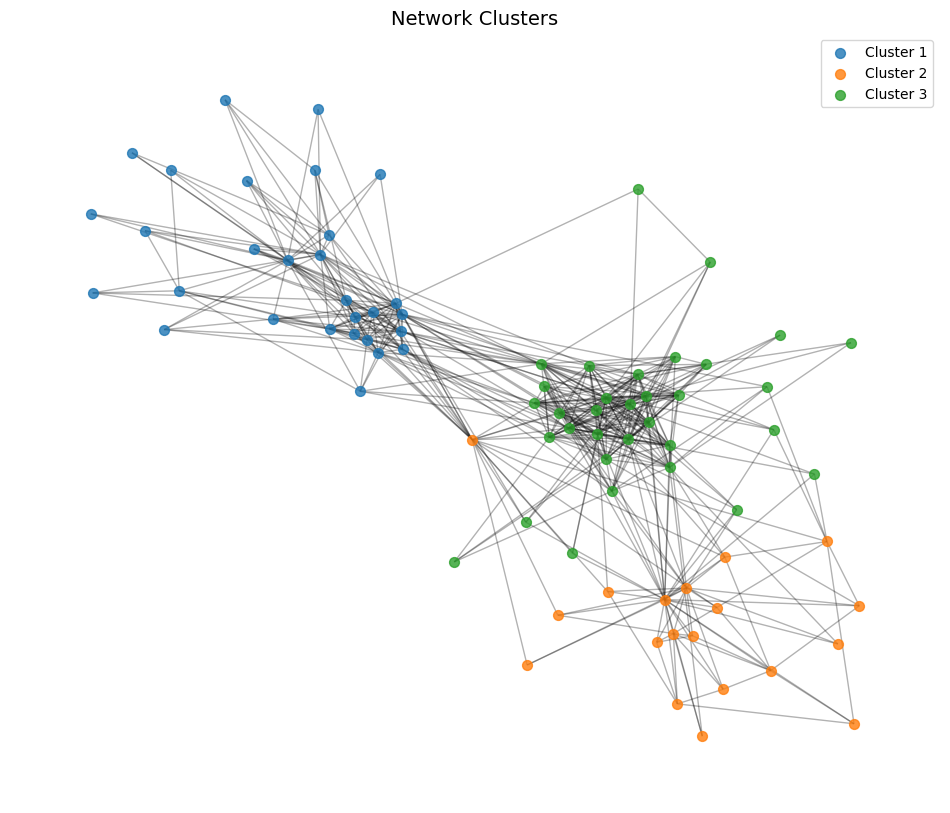

In [46]:
def clean_graph(G, min_degree=2, min_edge_weight=0.1):
    """
    Cleans the graph by removing isolated nodes, weak edges, and self-loops.
    
    Parameters:
        G (nx.Graph): The input NetworkX graph to be cleaned.
        min_degree (int): Minimum degree a node should have to remain in the graph.
        min_edge_weight (float): Minimum weight of an edge to remain in the graph.
        
    Returns:
        nx.Graph: The cleaned graph.
    """
    # Remove isolated nodes (nodes with degree 0)
    G.remove_nodes_from(list(nx.isolates(G)))
    
    # Remove self-loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    # Remove nodes with degree less than min_degree
    nodes_to_remove = [node for node, degree in dict(G.degree()).items() if degree < min_degree]
    G.remove_nodes_from(nodes_to_remove)
    
    # Remove edges with weight less than the minimum threshold (if weighted)
    weak_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('weight', 1) < min_edge_weight]
    G.remove_edges_from(weak_edges)
    
    # Optional: Keep only the largest connected component
    largest_component = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_component).copy()
    
    return G


# Detect clusters using Girvan-Newman
def get_communities_girvan_newman(G, num_clusters=4):
    """
    Applies Girvan-Newman algorithm and returns the top communities.
    
    Parameters:
        G (nx.Graph): Input graph
        num_clusters (int): Number of desired clusters
    
    Returns:
        list: List of sets, where each set is a cluster of nodes
    """
    communities = girvan_newman(G)
    for i, partition in enumerate(communities):
        if i == num_clusters - 2:
            return [set(c) for c in partition]
    return []

# Clean the Graph
cleaned_G = clean_graph(G, min_degree=3, min_edge_weight=0.5)

# Get clusters
clusters = get_communities_girvan_newman(cleaned_G, num_clusters=3)

# Visualize clusters
plot_network_clusters(cleaned_G, clusters)

In [47]:
def find_influential_users(G, clusters, centrality_measure='degree', top_n=5):
    """
    Finds the most influential users within each cluster based on a centrality measure.
    
    Parameters:
        G (nx.Graph): The input graph.
        clusters (list): List of clusters (sets of nodes).
        centrality_measure (str): Centrality measure to use ('degree', 'betweenness', 'closeness', 'eigenvector').
        top_n (int): Number of top users to return per cluster.
        
    Returns:
        dict: Dictionary with cluster indices as keys and lists of top users as values.
    """
    influential_users = {}

    for idx, cluster in enumerate(clusters):
        # Create subgraph for the cluster
        subgraph = G.subgraph(cluster)

        # Calculate centrality based on the selected measure
        if centrality_measure == 'degree':
            centrality = nx.degree_centrality(subgraph)
        elif centrality_measure == 'betweenness':
            centrality = nx.betweenness_centrality(subgraph)
        elif centrality_measure == 'closeness':
            centrality = nx.closeness_centrality(subgraph)
        elif centrality_measure == 'eigenvector':
            centrality = nx.eigenvector_centrality(subgraph, max_iter=1000)
        else:
            raise ValueError(f"Unsupported centrality measure: {centrality_measure}")

        # Sort users by centrality score
        sorted_users = sorted(centrality.items(), key=lambda x: x[1], reverse=True)

        # Take top_n users
        top_users = sorted_users[:top_n]
        influential_users[idx] = top_users

    return influential_users


# Example Usage
influential_users = find_influential_users(cleaned_G, clusters, centrality_measure='degree', top_n=5)

# Display influential users for each cluster
for cluster_idx, users in influential_users.items():
    print(f"Cluster {cluster_idx + 1}:")
    for user, score in users:
        print(f"  User {user} - Score: {score:.4f}")


Cluster 1:
  User 2882350436.0 - Score: 0.7857
  User 2882037326.0 - Score: 0.7500
  User 2882013788.0 - Score: 0.7143
  User 1727482238.0 - Score: 0.5714
  User 2589353987.0 - Score: 0.5000
Cluster 2:
  User 4224729994.0 - Score: 0.8889
  User 4272870988.0 - Score: 0.6667
  User 3990577513.0 - Score: 0.5556
  User 4332740714.0 - Score: 0.4444
  User 1679279490.0 - Score: 0.3333
Cluster 3:
  User 2572058134.0 - Score: 0.7500
  User 1690487623.0 - Score: 0.7500
  User 1646999972.0 - Score: 0.6875
  User 1649967228.0 - Score: 0.6875
  User 1660771422.0 - Score: 0.6562


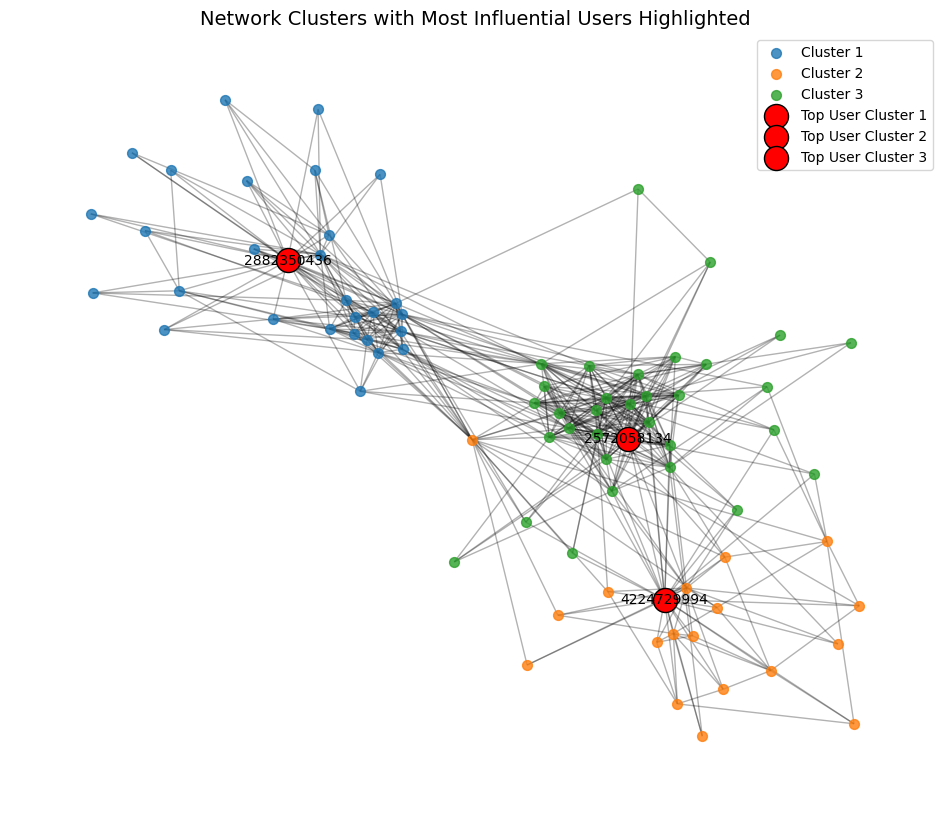

In [48]:
def plot_influential_users(G, clusters, influential_users):
    """
    Visualizes the network with clusters and highlights the most influential users.
    
    Parameters:
        G (nx.Graph): The input graph.
        clusters (list): List of clusters (sets of nodes).
        influential_users (dict): Dictionary of most influential users for each cluster.
    """
    # Define colors for clusters
    cluster_colors = plt.cm.tab10.colors
    
    # Create a position layout for the graph
    pos = nx.spring_layout(G, seed=42)  # Fix seed for consistent layout
    
    # Plot nodes and edges
    plt.figure(figsize=(12, 10))
    for idx, cluster in enumerate(clusters):
        nx.draw_networkx_nodes(
            G, pos, nodelist=cluster, node_color=[cluster_colors[idx % len(cluster_colors)]],
            node_size=50, label=f"Cluster {idx + 1}", alpha=0.8
        )
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    
    # Highlight the most influential user in each cluster
    for idx, top_users in influential_users.items():
        most_influential = top_users[0][0]  # Take the top user from the list
        nx.draw_networkx_nodes(
            G, pos, nodelist=[most_influential], node_color="red", node_size=300, 
            label=f"Top User Cluster {idx + 1}", edgecolors="black"
        )
    
    # Add labels to most influential users
    labels = {user[0]: f"{int(user[0])}" for cluster in influential_users.values() for user in cluster[:1]}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_color="black")
    
    # Add title and legend
    plt.title("Network Clusters with Most Influential Users Highlighted", fontsize=14)
    plt.legend(scatterpoints=1)
    plt.axis("off")
    plt.show()


# Visualize the results
plot_influential_users(cleaned_G, clusters, influential_users)


In [50]:
from collections import Counter

def get_top_user_hashtags(tweets_df, clusters, influential_users):
    """
    Extracts hashtags used by the top 5 users within each cluster.
    
    Parameters:
        tweets_df (pd.DataFrame): DataFrame containing tweets and their attributes.
        clusters (list): List of clusters (sets of nodes).
        influential_users (dict): Dictionary with top users for each cluster.
    
    Returns:
        dict: Dictionary with cluster IDs as keys and hashtag counts as values.
    """
    cluster_hashtags = {}

    for cluster_idx, top_users in influential_users.items():
        # Extract top 5 user IDs for this cluster
        top_user_ids = [user[0] for user in top_users[:5]]

        # Filter tweets for the top users
        user_tweets = tweets_df[tweets_df['user_id'].isin(top_user_ids)]

        # Extract and count hashtags
        hashtags = []
        for tag_list in user_tweets['hashtags']:
            if isinstance(tag_list, str):  # Ensure the hashtags field is valid
                hashtags.extend(eval(tag_list))  # Convert string representation to list

        # Count hashtag occurrences
        hashtag_counts = Counter(hashtags)

        # Store the result
        cluster_hashtags[cluster_idx] = hashtag_counts.most_common(10)  # Top 10 hashtags

    return cluster_hashtags

# Call the function
hashtags_by_cluster = get_top_user_hashtags(tweets_df, clusters, influential_users)

# Display results
for cluster_idx, hashtags in hashtags_by_cluster.items():
    print(f"Cluster {cluster_idx + 1}:")
    for tag, count in hashtags:
        print(f"  #{tag} - {count} times")


Cluster 1:
  #MakeMeHateYouInOnePhrase - 401 times
  #IdRunForPresidentIf - 323 times
  #RuinADinnerInOnePhrase - 314 times
  #SometimesItsOkTo - 314 times
  #ThingsNotTaughtAtSchool - 282 times
  #RealLifeMagicSpells - 280 times
  #RejectedDebateTopics - 260 times
  #ImTooOldFor - 258 times
  #ChristmasAftermath - 258 times
  #BetterAlternativeToDebates - 252 times
Cluster 2:
  #maga - 672 times
  #Trump - 373 times
  #NeverHillary - 334 times
  #Trump2016 - 274 times
  #TrumpTrain - 217 times
  #TrumpPence16 - 205 times
  #Debate - 190 times
  #tcot - 190 times
  #debatenight - 186 times
  #MakeAmericaGreatAgain - 142 times
Cluster 3:
  #tcot - 280 times
  #maga - 167 times
  #pjnet - 146 times
  #Trump - 107 times
  #IslamKills - 101 times
  #WakeUpAmerica - 88 times
  #HappyBirthdayHarryTruman - 79 times
  #ThingsMoreTrustedThanHillary - 66 times
  #OscarHasNoColor - 65 times
  #TrumpBecause - 63 times


### Problem 2 

Prepare an infographics/presentation/report containing the most interesting conclusions from the analysis of the results of the previous task.

### Solution 